The problem is an example of binary classification problem. 

In [561]:
import pandas as pd

Load data and get to know it a bit

In [562]:
df = pd.read_parquet('data/data.parquet', engine='auto')
df.shape 

(18466364, 3)

In [563]:
labels = pd.read_csv('data/labels.csv')
labels.shape

(27385, 5)

In [564]:
df.head()

,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0


In [565]:
labels.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN


In [566]:
# Just to be sure that we have the same numer of machines and measurements in both dataframes
print("Unique machines in df", df['MachineId'].unique().shape)
print("Unique machines in labels", labels['MachineId'].unique().shape)
print("Unique measurements in df", df['MeasurementId'].unique().shape)
print("Unique measurements in labels", labels['MeasurementId'].unique().shape)

Unique machines in df (556,)
Unique machines in labels (556,)
Unique measurements in df (8836,)
Unique measurements in labels (8836,)


### Data cleaning

In [567]:
# drop rows with missing labels in our target column
labels.dropna(subset=["PumpFailed"], inplace=True)
labels.shape

(26900, 5)

In [568]:
# deleting values that are not target values and contain a lot of missing values
labels.drop(columns=["SlowEnd", "SlowStart"], inplace=True)

In [569]:
# keep only measurements with the remaining labels
df_filtered = df.merge(labels[['MachineId', 'MeasurementId']], on=['MachineId', 'MeasurementId'], how='inner')
df_filtered.shape

(13195033, 3)

In [570]:
# checking how the numbers have changed after filtering
print("Unique machines in labels", labels['MachineId'].unique().shape)
print("Unique measurements in labels", labels['MeasurementId'].unique().shape)

Unique machines in labels (374,)
Unique measurements in labels (8835,)


First of all, I want to know how do failures and normal measurements look like:

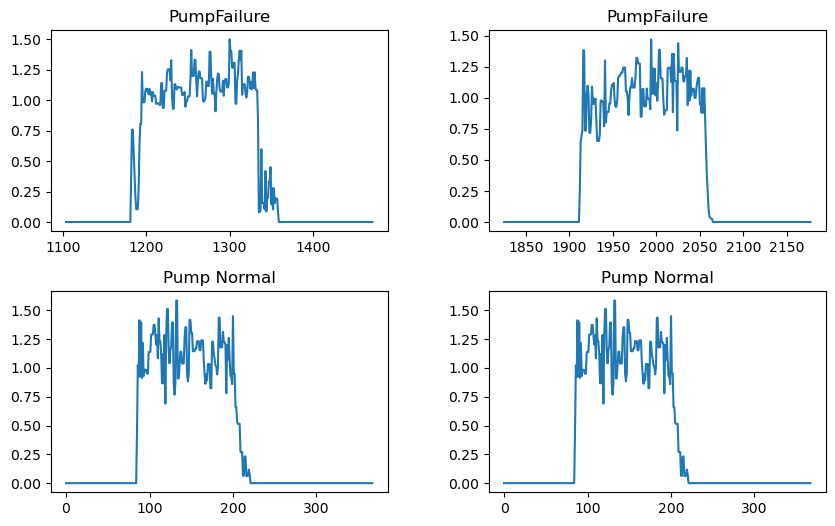

In [571]:
import matplotlib.pyplot as plt

# get data for two pump failures and two normal pumps
pump_failure_1 = df[(df['MachineId'] == '0_0_3') & (df['MeasurementId'] == 0)]
pump_failure_2 = df[(df['MachineId'] == '0_1_1') & (df['MeasurementId'] == 1)]
pump_normal_1 = df[(df['MachineId'] == '0_0_0') & (df['MeasurementId'] == 0)]
pump_normal_2 = df[(df['MachineId'] == '0_0_0') & (df['MeasurementId'] == 0)]

# Plot the graph to see the examples of pump failure and normal pump
plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
plt.plot(pump_failure_1['Pressure'])
plt.title(f'PumpFailure')

plt.subplot(2, 2, 2)
plt.title(f'PumpFailure')
plt.plot(pump_failure_2['Pressure'])

plt.subplot(2, 2, 3)
plt.title(f'Pump Normal')
plt.plot(pump_normal_1['Pressure'])

plt.subplot(2, 2, 4)
plt.title(f'Pump Normal')
plt.plot(pump_normal_2['Pressure'])

plt.show()


### Feature Engineering

Ok, now we can get to the feature engineering.  First features that come to mind are basic statistical descriptors, such as mean, standard deviation, min and max values.

In [572]:
# let's sort the data by MachineId and MeasurementId
df_filtered = df_filtered.sort_values(by=['MachineId', 'MeasurementId'])

# create first features
statistical_features = df_filtered.groupby(['MachineId', 'MeasurementId'])['Pressure'].agg(['mean', 'std', 'min', 'max']).reset_index()
features_labels = pd.merge(statistical_features, labels, on=['MachineId', 'MeasurementId'], how='inner')
features_labels.head()  

,MachineId,MeasurementId,mean,std,min,max,PumpFailed
0,0_0_0,0,0.375074,0.534507,0.0,1.584466,False
1,0_0_0,215,0.355364,0.625983,0.0,1.838710,False
2,0_0_0,237,0.499585,0.693371,0.0,1.927632,False
3,0_0_0,353,0.480250,0.408381,0.0,1.275996,False
4,0_0_0,411,0.487980,0.616258,0.0,1.922395,True


In [573]:
final_df = features_labels[['MachineId', 'MeasurementId', 'mean', 'std', 'min', 'max', 'PumpFailed']]
final_df.shape

(26900, 7)

### Training

Ok, now we have something that we can train an actual classifier on. So let's do that and check how we are doing. Firs let's check the data type of the target value:

In [574]:
final_df['PumpFailed'].dtype

dtype('O')

In [575]:
# the target value is of type object, so let's convert it to boolean
final_df["PumpFailed"] = final_df["PumpFailed"].astype(bool)

In [576]:
final_df['PumpFailed'].dtype

dtype('bool')

In [577]:
from sklearn.model_selection import train_test_split

# divide the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(['PumpFailed', "MeasurementId", "MachineId"], axis=1), final_df['PumpFailed'], test_size=0.2, random_state=42)

Let's fit the first classifier. I like to start with SGD classifier so let's train it and assess the performance:

In [578]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") 

array([0.89015891, 0.89028301, 0.89028301])

too good to be true :D Let's check with other methods

In [579]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
confusion_matrix(y_train, y_train_pred)


array([[19158,     0],
       [ 2362,     0]])

Uups! The model predicts `false` no matter the features. It likely happens due to the class imbalance in the target column.

In [580]:
confusion_matrix(y_train, y_train) # for reference

array([[19158,     0],
       [    0,  2362]])

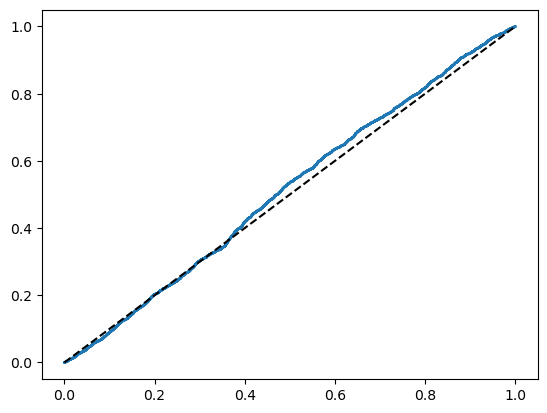

In [581]:
from sklearn.metrics import roc_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3,
                                 method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [582]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
print("ROC AUC Score: ", roc_auc_score(y_train, y_scores))
print("Precision Score: ", precision_score(y_train, y_train_pred))
print("Recall Score: ", recall_score(y_train, y_train_pred))
print("F1 Score: ", f1_score(y_train, y_train_pred))

ROC AUC Score:  0.5129990155398323
Precision Score:  0.0
Recall Score:  0.0
F1 Score:  0.0


/Users/kyrylo/anaconda3/envs/datamole/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ok, the model is bad. The there are two problems: engineered features are not descriptive enough and imbalanced dataset. Let's check the latter:

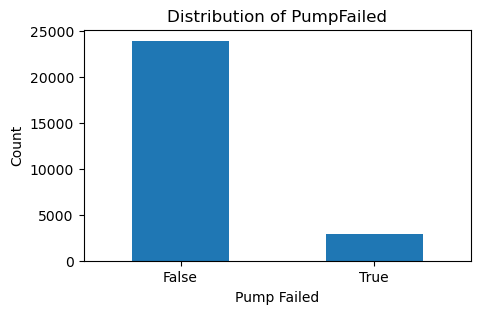

In [583]:
import matplotlib.pyplot as plt

# the dataset is highly imbalanced
labels['PumpFailed'].value_counts().plot(kind='bar', figsize=(5, 3))
plt.title('Distribution of PumpFailed')
plt.xlabel('Pump Failed')
plt.ylabel('Count')
plt.xticks([0, 1], ['False', 'True'], rotation=0)
plt.show()

Indeed, the dataset is highly imbalanced. Let's fix this with undersampling:

In [584]:
from imblearn.under_sampling import RandomUnderSampler


print("Class Distribution Before Under-sampling:", final_df['PumpFailed'].value_counts())

rnd_us = RandomUnderSampler(random_state=42)
features_resampled, labels_resampled = rnd_us.fit_resample(final_df.drop('PumpFailed', axis=1), final_df['PumpFailed'].astype(int))

df_resampled = pd.concat([pd.DataFrame(features_resampled), pd.Series(labels_resampled, name='PumpFailed')], axis=1)

print("\nClass Distribution After Under-sampling:",  df_resampled['PumpFailed'].value_counts())

Class Distribution Before Under-sampling: PumpFailed
False    23958
True      2942
Name: count, dtype: int64

Class Distribution After Under-sampling: PumpFailed
0    2942
1    2942
Name: count, dtype: int64


That's better. Let's train a model again and see what changed:

In [585]:
from sklearn.model_selection import train_test_split

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(features_resampled.drop(['MeasurementId'], axis=1), labels_resampled, test_size=0.2, random_state=42)

In [586]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_resampled, y_train_resampled)

cross_val_score(sgd_clf, X_train_resampled, y_train_resampled, cv=3, scoring="accuracy")

array([0.58253665, 0.5583174 , 0.56341619])

In [587]:
y_train_pred_resampled = cross_val_predict(sgd_clf, X_train_resampled, y_train_resampled, cv=3)
confusion_matrix(y_train_resampled, y_train_pred_resampled)

array([[ 809, 1519],
       [ 514, 1865]])

Much closer to reality. Let's now look at feature importances to see what might be wrong:

In [590]:
feature_names = final_df.drop(['PumpFailed', 'MeasurementId'], axis=1).columns
feature_importance = pd.Series(sgd_clf.coef_[0], index=feature_names).sort_values(ascending=False)
print(feature_importance)


max          335.092806
std           79.285301
MachineId     28.700754
mean          13.544437
min            0.000000
dtype: float64


A-ha! My assumption that `machineId` might be predictive in any way is wrong, the same is with `slowStart` and `SlowEnd`. Let's train a model without them. 

UPD: this is obsolete, I wanted to check how all these feature might affect performance. (I know that these are labels:) ) At the moment these values were negative. I decided to drop SlowStart and SlowEnd at the beginning because they have a lot of NaN values and `dropna()` combined with class undersampling made the dataset too miniscule.

In [591]:
# train test split of resampled data
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(features_resampled.drop(['mean', 'MachineId', 'MeasurementId'], axis=1), labels_resampled, test_size=0.2, random_state=42)

In [592]:
# let's train the model aon the resampled data
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_resampled, y_train_resampled)

cross_val_score(sgd_clf, X_train_resampled, y_train_resampled, cv=3, scoring="accuracy")

array([0.486297  , 0.55640535, 0.52071383])

In [593]:
y_train_pred_resampled = cross_val_predict(sgd_clf, X_train_resampled, y_train_resampled, cv=3)
confusion_matrix(y_train_resampled, y_train_pred_resampled)

array([[1322, 1006],
       [1248, 1131]])

In [594]:
# print("ROC AUC Score: ", roc_auc_score(y_train, y_scores))
print("Precision Score: ", precision_score(y_train_resampled, y_train_pred_resampled))
print("Recall Score: ", recall_score(y_train_resampled, y_train_pred_resampled))
print("F1 Score: ", f1_score(y_train_resampled, y_train_pred_resampled))

Precision Score:  0.5292466073935423
Recall Score:  0.47540983606557374
F1 Score:  0.5008857395925598


No too good, but better than zero) Now we have to come up with new features

We are working with time-series data. A little bit of googling led me to the technique called Lag Features. Let's implement it:

In [595]:
import pandas as pd

# just to be sure
df_filtered = df_filtered.sort_values(by=['MachineId', 'MeasurementId'])

num_lags = 5  # number of lags to create

for i in range(1, num_lags + 1):
    df_filtered[f'Pressure_lag_{i}'] = df_filtered.groupby('MachineId')['Pressure'].shift(i)

aggregated_lagged_features = df_filtered.groupby(['MachineId', 'MeasurementId']).agg({
    'Pressure_lag_1': ['mean', 'std', 'min', 'max'],
    'Pressure_lag_2': ['mean', 'std', 'min', 'max'],
    'Pressure_lag_3': ['mean', 'std', 'min', 'max'],
    'Pressure_lag_4': ['mean', 'std', 'min', 'max'],
    'Pressure_lag_5': ['mean', 'std', 'min', 'max']
}).reset_index()

aggregated_lagged_features.columns = [' '.join(col).strip() for col in aggregated_lagged_features.columns.values]

new_df = pd.merge(features_resampled, aggregated_lagged_features, on=['MachineId', 'MeasurementId'], how='left')

new_df = new_df.dropna()

new_df.head()


,MachineId,MeasurementId,mean,std,min,max,Pressure_lag_1 mean,Pressure_lag_1 std,Pressure_lag_1 min,Pressure_lag_1 max,...,Pressure_lag_3 min,Pressure_lag_3 max,Pressure_lag_4 mean,Pressure_lag_4 std,Pressure_lag_4 min,Pressure_lag_4 max,Pressure_lag_5 mean,Pressure_lag_5 std,Pressure_lag_5 min,Pressure_lag_5 max
0,0_2_2,7449,0.346348,0.569172,0.0,1.708423,0.346348,0.569172,0.0,1.708423,...,0.0,1.708423,0.346348,0.569172,0.0,1.708423,0.346348,0.569172,0.0,1.708423
1,0_1_3,3785,0.459135,0.453392,0.0,1.238322,0.459135,0.453392,0.0,1.238322,...,0.0,1.238322,0.459135,0.453392,0.0,1.238322,0.459135,0.453392,0.0,1.238322
2,4_1_1,1656,0.330696,0.528453,0.0,1.390403,0.330696,0.528453,0.0,1.390403,...,0.0,1.390403,0.330696,0.528453,0.0,1.390403,0.330696,0.528453,0.0,1.390403
3,4_1_0,8052,0.497442,0.484888,0.0,1.369149,0.497442,0.484888,0.0,1.369149,...,0.0,1.369149,0.497442,0.484888,0.0,1.369149,0.497442,0.484888,0.0,1.369149
4,27_2_0,4459,0.426161,0.326587,0.0,0.861233,0.426161,0.326587,0.0,0.861233,...,0.0,0.861233,0.426161,0.326587,0.0,0.861233,0.426161,0.326587,0.0,0.861233


In [596]:
new_df.shape

(5884, 26)

Now that we have extended dataset, let's look how different models perform on it:

In [597]:
from sklearn.model_selection import train_test_split

# setting trainig and test data
X = new_df.drop(["MeasurementId", "MachineId"], axis=1)
y = labels_resampled

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=42)

In [598]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# further we will train a lot of models so let's create a function to evaluate them
# to avoid code duplication
def evaluate_model(model, X_train, y_train):
    # Cross-validation accuracy score
    accuracy_scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    print(f"Cross-Validation Accuracy: {accuracy_scores.mean():.4f} (±{accuracy_scores.std():.4f})")

    # Cross-validation predictions
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=3)

    # Confusion matrix
    conf_mat = confusion_matrix(y_train, y_train_pred)
    print("Confusion Matrix:")
    print(conf_mat)

    # Precision, Recall, and F1 Score
    precision = precision_score(y_train, y_train_pred)
    recall = recall_score(y_train, y_train_pred)
    f1 = f1_score(y_train, y_train_pred)

    print(f"Precision Score: {precision:.4f}")
    print(f"Recall Score: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


### Selecting the best model
Here we will test a lot of different models to see which fits data the best.

In [599]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_new, y_train_new)

# cross_val_score(sgd_clf, X_train_new, y_train_new, cv=3, scoring="accuracy")
evaluate_model(sgd_clf, X_train_new, y_train_new)

Cross-Validation Accuracy: 0.5184 (±0.0216)
Confusion Matrix:
[[ 913 1415]
 [ 852 1527]]
Precision Score: 0.5190
Recall Score: 0.6419
F1 Score: 0.5740


In [600]:
# just checking the feature importance
feature_names = new_df.drop(["MeasurementId", "MachineId"], axis=1).columns
feature_importance = pd.Series(sgd_clf.coef_[0], index=feature_names).sort_values(ascending=False)
print(feature_importance)

Pressure_lag_5 mean    0.375252
Pressure_lag_5 std     0.369118
Pressure_lag_4 std     0.341335
Pressure_lag_3 std     0.313945
Pressure_lag_2 std     0.285995
Pressure_lag_1 std     0.257592
std                    0.228129
Pressure_lag_4 mean    0.156941
min                    0.000000
Pressure_lag_5 min     0.000000
Pressure_lag_1 min     0.000000
Pressure_lag_2 min     0.000000
Pressure_lag_4 min     0.000000
Pressure_lag_3 min     0.000000
Pressure_lag_5 max    -0.028610
Pressure_lag_4 max    -0.048109
Pressure_lag_3 mean   -0.058564
Pressure_lag_3 max    -0.076470
Pressure_lag_2 max    -0.076470
Pressure_lag_1 max    -0.076470
Pressure_lag_2 mean   -0.271871
max                   -0.287605
Pressure_lag_1 mean   -0.481852
mean                  -0.691045
dtype: float64


In [601]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_new, y_train_new)
evaluate_model(rf_clf, X_train_new, y_train_new)

Cross-Validation Accuracy: 0.5322 (±0.0077)
Confusion Matrix:
[[1232 1096]
 [1106 1273]]
Precision Score: 0.5374
Recall Score: 0.5351
F1 Score: 0.5362


In [602]:
from sklearn.svm import SVC

svc_clf = SVC()
svc_clf.fit(X_train_new, y_train_new)
evaluate_model(svc_clf, X_train_new, y_train_new)

Cross-Validation Accuracy: 0.5547 (±0.0264)
Confusion Matrix:
[[1039 1289]
 [ 807 1572]]
Precision Score: 0.5495
Recall Score: 0.6608
F1 Score: 0.6000


In [603]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_new, y_train_new)
evaluate_model(gb_clf, X_train_new, y_train_new)

Cross-Validation Accuracy: 0.5536 (±0.0144)
Confusion Matrix:
[[1042 1286]
 [ 815 1564]]
Precision Score: 0.5488
Recall Score: 0.6574
F1 Score: 0.5982


In [604]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(random_state=42)
ada_clf.fit(X_train_new, y_train_new)
evaluate_model(ada_clf, X_train_new, y_train_new)

Cross-Validation Accuracy: 0.5636 (±0.0073)
Confusion Matrix:
[[1053 1275]
 [ 779 1600]]
Precision Score: 0.5565
Recall Score: 0.6726
F1 Score: 0.6091


In [605]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_new, y_train_new)
evaluate_model(gnb, X_train_new, y_train_new)

Cross-Validation Accuracy: 0.5577 (±0.0143)
Confusion Matrix:
[[ 849 1479]
 [ 603 1776]]
Precision Score: 0.5456
Recall Score: 0.7465
F1 Score: 0.6305


In [606]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(random_state=42)
mlp_clf.fit(X_train_new, y_train_new)
evaluate_model(mlp_clf, X_train_new, y_train_new)


Cross-Validation Accuracy: 0.5543 (±0.0090)
Confusion Matrix:
[[ 707 1621]
 [ 477 1902]]
Precision Score: 0.5399
Recall Score: 0.7995
F1 Score: 0.6445


In [607]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_new, y_train_new)
evaluate_model(knn_clf, X_train_new, y_train_new)

Cross-Validation Accuracy: 0.5148 (±0.0087)
Confusion Matrix:
[[1133 1195]
 [1089 1290]]
Precision Score: 0.5191
Recall Score: 0.5422
F1 Score: 0.5304


| Model | Cross-Validation Accuracy | Precision Score | Recall Score | F1 Score |
|-------|--------------------------|-----------------|--------------|----------|
| SGD Classifier | 0.5184 (±0.0216) | 0.5190 | 0.6419 | 0.5740 |
| Random Forest Classifier | 0.5322 (±0.0077)  | 0.5374 | 0.5351 | 0.5362 |
| Support Vector Classifier | 0.5547 (±0.0264) | 0.5495 | 0.6608 | 0.6000 |
| Gradient Boosting Classifier | 0.5536 (±0.0144) | 0.5488 | 0.6574 | 0.5982 |
| AdaBoost Classifier | 0.5636 (±0.0073) | 0.5565 | 0.6726 | 0.6091 |
| Gaussian Naive Bayes | 0.5577 (±0.0143) | 0.5456 | 0.7465 | 0.6305 |
| MLP Classifier | 0.5543 (±0.0090) | 0.5399 | 0.7995 | 0.6445 |
| K Neighbors Classifier | 0.5148 (±0.0087) | 0.5191 | 0.5422 | 0.5304 |

The choice of the model would now depend on the customer's requirements: if the customer is ok with false alarms, but wants to capture as many failures as possible, the MLP classifier would be the model of choice (as it has high recall score); if customer is not ok with false alarms and he wants that the number of false-negatives and the number of false-positives were as close as possible, then the AdaBoost Classifier would be our choice (highest precision score).

Then we would fine tune the model, test it on the test set and then deploy it.

Let's finetune MLP classifier:

In [608]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(200,), (300,), (400,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01, 0.1], # 0.0001, 0.001, 
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(random_state=42)

grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train_new, y_train_new)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant'}
Best Score:  0.5676651795198641


In [609]:
best_model = grid_search.best_estimator_
print(best_model)


MLPClassifier(alpha=0.01, hidden_layer_sizes=(200,), random_state=42)


In [611]:
best_model.predict(X_train_new)

array([0, 1, 0, ..., 0, 1, 1])

### Closing remarks


It is far from idel, but I hope I was able to show my understanding of the machine learning. This is my first project on time-series data so I hope it was not too bad.
If I could I would spend more time on feature engineering. And if the acceptability of false-positives/false-negatives was known I would spend more time on the selected model's hyperparameter tuning. Anyway, thank you for reviewing this Jupyter notebook.